# Conformational analysis of CXCL12

In this tutorial, we demonstrate how to use the HTMD code for doing conformational analysis.

To analyze, one needs MD trajectories first, which can be generated with HTMD. Here, we already provide the trajectories (data) to analyze. You can download the data from [here](http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/cxcl12_filtered.tar.gz). (**Warning: 2.6 GB filesize**)

Alternatively, you can download the dataset using `wget`.

In [ ]:
import os
assert os.system('wget -rcN -np -nH -q --cut-dirs=2 -R index.html* http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/cxcl12_filtered/') == 0

## Getting started

First we import the modules we are going to need for the tutorial:

In [1]:
from htmd.ui import *
from matplotlib import pylab as plt
from moleculekit.config import config

config(viewer='webgl')

2024-06-12 11:53:02,703 - numexpr.utils - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-06-12 11:53:02,704 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-06-12 11:53:02,858 - rdkit - INFO - Enabling RDKit 2022.09.1 jupyter extensions



Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049
HTMD Documentation at: https://software.acellera.com/htmd/

You are on the latest HTMD version (2.3.28+8.g0ec8f27eb.dirty).



## Introduction to CXCL12

CXCL12 is a chemokine involved in...

*  many types of cancer 
*  inflammatory diseases 
*  early development events

![system](img/system-protein2.png)

## Sampling major conformational states

There are many different metrics to assess the overall conformational changes of a protein. From them all, phi and psi angles of the protein backbone (dihedrals) have been the most successful descriptors in "blindly" capturing the major protein conformations.

In this section we will project our trajectories on the backbone dihedrals and, we will reduce the dimensionality by using tICA and then we will build a Markov Model to asses the major protein conformations in equilibrium.

![conformations](img/conformations.png)

## Load the trajectories into a simlist

In [3]:
fsims = simlist(glob('./cxcl12_filtered/*/'), './cxcl12_filtered/')

Creating simlist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:01<00:00, 226.23it/s]


## Calculate metrics: protein backbone dihedrals

CXCL12 has a very flexible C-terminus loop as well as a transiently disorderable N-terminal alfa helix. In this study we are not interested in them but in the core of the chemokine. For this reason, we will select residues from 10 to 54. 

In [4]:
metr = Metric(fsims)
metr.set(MetricDihedral(protsel='protein and resid 10 to 54', sincos=True))
data = metr.project()
data.fstep = 0.1

Projecting trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:37<00:00,  7.79it/s]
2024-06-12 11:48:59,344 - htmd.projections.metric - WARNING - Multiple framesteps [0.0, 0.1] ns were read from the simulations. Taking the statistical mode: 0.1ns. If it looks wrong, you can modify it by manually setting the MetricData.fstep property.


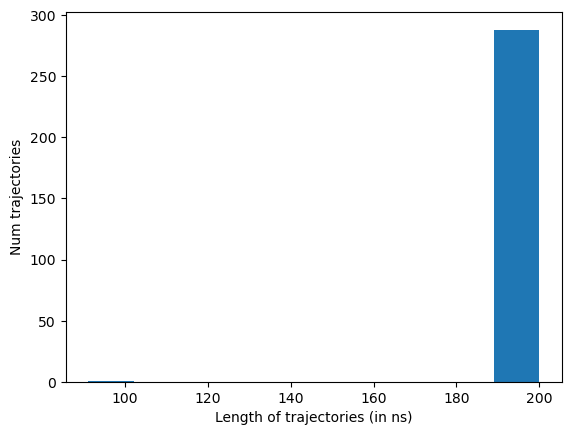

In [5]:
data.plotTrajSizes()

In [6]:
data.dropTraj()

2024-06-12 11:48:59,461 - htmd.metricdata - INFO - Dropped 1 trajectories from 289 resulting in 288


array([145])

##  Dimensionality reduction

In [7]:
tica = TICA(data, 20)
dataTica = tica.project(3)

## Clustering

In [8]:
dataTica.cluster(MiniBatchKMeans(n_clusters=200), mergesmall=5)

2024-06-12 11:49:04,110 - htmd.metricdata - INFO - Mergesmall removed 0 clusters. Original ncluster 200, new ncluster 200.


## MSM analysis and visualization

Estimating Timescales: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.20it/s]


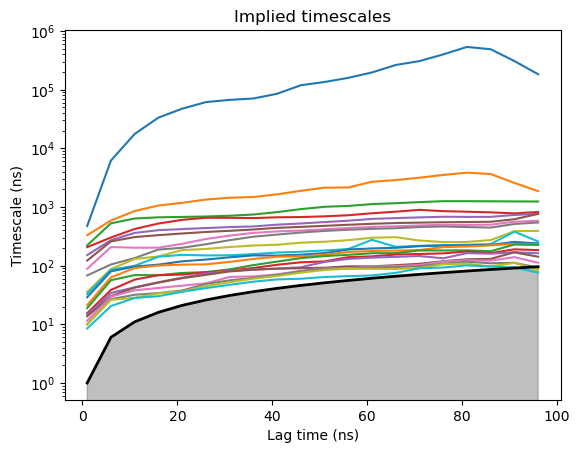

In [9]:
model = Model(dataTica)
model.plotTimescales(lags=list(range(1,100,5)), units="ns")

## Build Markov Model

2024-06-12 11:49:23,206 - htmd.model - WARNING - PCCA returned empty macrostates. Reducing the number of macrostates to 7.
2024-06-12 11:49:23,701 - htmd.model - INFO - 99.7% of the data was used
2024-06-12 11:49:23,721 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2024-06-12 11:49:23,722 - htmd.model - INFO - [ 38  62  29   8 288  11  11]


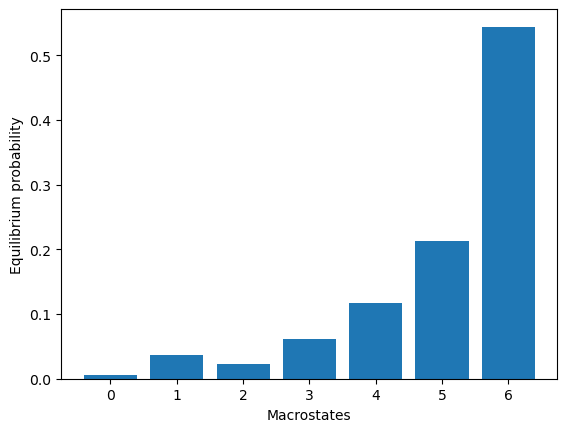

In [10]:
model.markovModel(60, 8, units="ns")
eqDist = model.eqDistribution()

We can now visualize representatives for each of the equilibrium species

In [11]:
model.numsamples=1
model.viewStates(protein=True)

Getting state Molecules: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.20it/s]


NGLWidget()

## Statistics: What are the major differences between the states X and Y?

,type,atomIndexes,description
24,dihedral,"[253, 255, 262, 264]",Sine of angle of (SER 16 N A A) (SER 16 CA A A...
25,dihedral,"[253, 255, 262, 264]",Cosine of angle of (SER 16 N A A) (SER 16 CA A...
26,dihedral,"[262, 264, 266, 279]",Sine of angle of (SER 16 C A A) (HSD 17 N A A)...
57,dihedral,"[371, 373, 391, 393]",Cosine of angle of (LYS 24 N A A) (LYS 24 CA A...
59,dihedral,"[391, 393, 395, 408]",Cosine of angle of (LYS 24 C A A) (HSD 25 N A ...
88,dihedral,"[517, 521, 529, 531]",Sine of angle of (PRO 32 N A A) (PRO 32 CA A A...
89,dihedral,"[517, 521, 529, 531]",Cosine of angle of (PRO 32 N A A) (PRO 32 CA A...
90,dihedral,"[529, 531, 533, 543]",Sine of angle of (PRO 32 C A A) (ASN 33 N A A)...
136,dihedral,"[711, 713, 723, 725]",Sine of angle of (ASN 44 N A A) (ASN 44 CA A A...
137,dihedral,"[711, 713, 723, 725]",Cosine of angle of (ASN 44 N A A) (ASN 44 CA A...


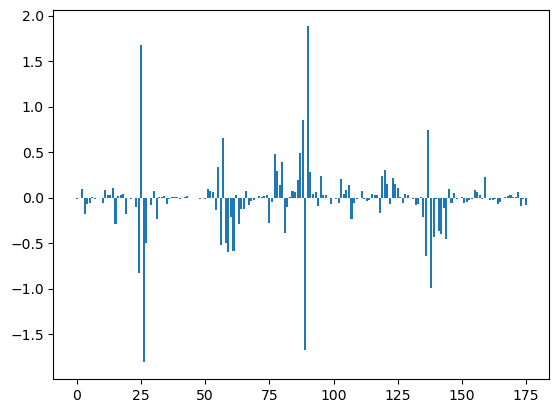

In [12]:
means = getStateStatistic(model, data, range(model.macronum))
plt.figure()
plt.bar(range(len(means[0])), means[-1] - means[-2])
idx = np.where(np.abs(means[-1] - means[-2]) > 0.6)[0]
data.map.iloc[idx]

In [13]:
# we can visualize which residues are different between states
filtered = Molecule('./cxcl12_filtered/filtered.pdb')
filtered.view(sel='protein',style='NewCartoon',hold=True)
filtered.view(sel='resid 16 17 24 25 32 33 44 45',style='Licorice')

NGLWidget()

## Mapping back: Which trajectory originated the state X?

In [14]:
np.where(model.macro_ofmicro == 6)

(array([  3, 100, 110, 168, 184]),)

In [15]:
_,rel = model.sampleStates(10, 10, statetype='micro')
print(rel)

[array([[ 264, 1527],
       [ 264,  690],
       [ 264, 1176],
       [ 264, 1657],
       [ 264,  466],
       [ 264, 1335],
       [ 264, 1019],
       [ 264, 1853],
       [ 264,  583],
       [ 264,  862]])]


In [16]:
print(model.data.simlist[232])


simid = 233
parent = None
input = []
trajectory = ['./cxcl12_filtered/9x10/9x10-GERARD_VERYLONG_CXCL12_confAna-0-1-RND1051_9.filtered.xtc']
molfile = ['./cxcl12_filtered/filtered.pdb', './cxcl12_filtered/filtered.psf']
numframes = [2000]



## Studying a defined reaction coordinate

Revising the literature related to CXCL12, we find a paper published by Andrea Bernini et al. (2014), where they describe the opening of a pocket in CXCL12 located between the 2nd and 3rd beta sheet (see figure). To try to capture this phenomenon in our simulations, we will project our trajectories along the 2nd and 3rd beta-sheet distance.

![openclose_struc](img/openclose_struc.jpg)

_Figure taken from Bernini et al., 2014, 1844(3):561-6. DOI:10.1016/j.bbapap.2013.12.012._

The first selection corresponds to beta-sheet 2 carbons alpha, the second one to beta-sheet 3 CA.
We specify `metric='contacts'` to create contact maps instead of proper distances. This means: create an interatom matrix and with 1's if the distance is below cutoff and 0's otherwise.

In [17]:
metr = Metric(fsims)
metr.set(MetricDistance('resid 38 to 42 and noh', 'resid 22 to 28 and noh', periodic=None, metric='contacts'))
data3 = metr.project()

Projecting trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:38<00:00,  7.50it/s]
2024-06-12 11:50:32,963 - htmd.projections.metric - WARNING - Multiple framesteps [0.0, 0.1] ns were read from the simulations. Taking the statistical mode: 0.1ns. If it looks wrong, you can modify it by manually setting the MetricData.fstep property.


## tICA projection

Dimensionality reduction along the slow process

In [ ]:
tica3 = TICA(data3, 20)
dataTica3 = tica3.project(3)

## Clustering

In [ ]:
dataTica3.cluster(MiniBatchKMeans(n_clusters=200), mergesmall=5)

## Plot timescales

In [ ]:
model3 = Model(dataTica3)
model3.plotTimescales(lags=list(range(1,100,5)), units="ns")

## Build a Markov Model

We want to pick a lagtime where the timescales are converged (timescale is flat). 600 is the lagtime we want to use (600 frames is equivalent to 60ns). 4 is the number of macrostates.

In [ ]:
model3.markovModel(60, 4, units="ns")
eqDist = model3.eqDistribution(plot=True)

## Visualize states

In [ ]:
model3.viewStates(protein=True, numsamples=1)

## Analyse Open Conformation

Did you see any macrostate where the pocket is open? What is the equilibrium population probability? Let's try to find the trajectory that produced the state...

In [ ]:
# Map back the trajectory/ies that originated the macro. Substitute 1 for the macro that showed the pocket opening.
# This function is giving you the microclusters that are inside a given macrocluster

In [ ]:
np.where(model3.macro_ofmicro ==1)

In [ ]:
# substitute 48 for the micro number from the previous step
# This function gives you trajectory-frame pairs that visited a given micro
_, rel = model3.sampleStates(48, 5, statetype='micro')
print(rel)

In [ ]:
print(model3.data.simlist[277])

## Calculate RMSD of the site of interest for a selected trajectory

In [4]:
simus = simlist(glob('./cxcl12_filtered/10x23/'), './cxcl12_filtered/')

Creating simlist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.15it/s]


In [6]:
refmol = Molecule('./cxcl12_filtered/filtered.pdb')
metr = Metric(simus)
metr.set(MetricRmsd(refmol, 'resid 38 to 42 or resid 22 to 28 and noh'))
rmsd = metr.project()

Projecting trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]
2024-06-12 11:53:43,783 - htmd.projections.metric - INFO - Frame step 0.1ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


## Do you see the pocket opening at 50ns?

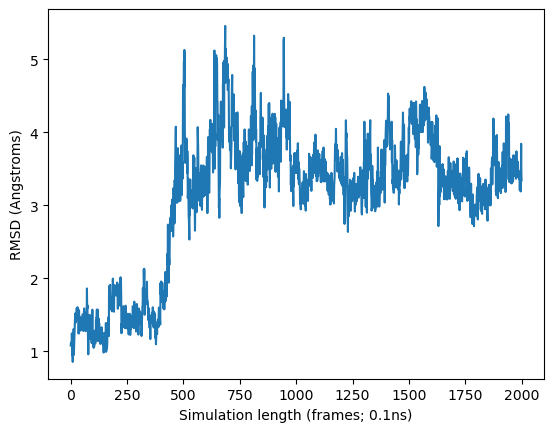

In [7]:
plt.plot(rmsd.dat[0])
plt.xlabel('Simulation length (frames; 0.1ns)', fontsize=10)
plt.ylabel('RMSD (Angstroms)', fontsize=10)
plt.show()

## Visualize the trajectory from your browser

In [9]:
refmol.read('./cxcl12_filtered/10x23/10x23-GERARD_VERYLONG_CXCL12_confAna-0-1-RND9861_9.filtered.xtc')
refmol.align('protein')
refmol.view()

NGLWidget(max_frame=1999)

This concludes the conformational analysis tutorial